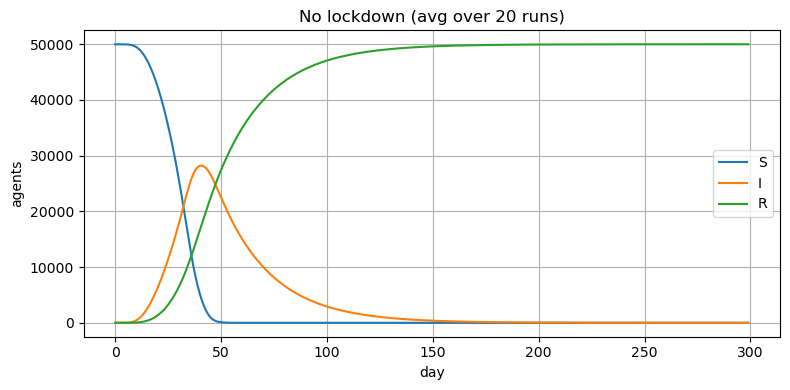

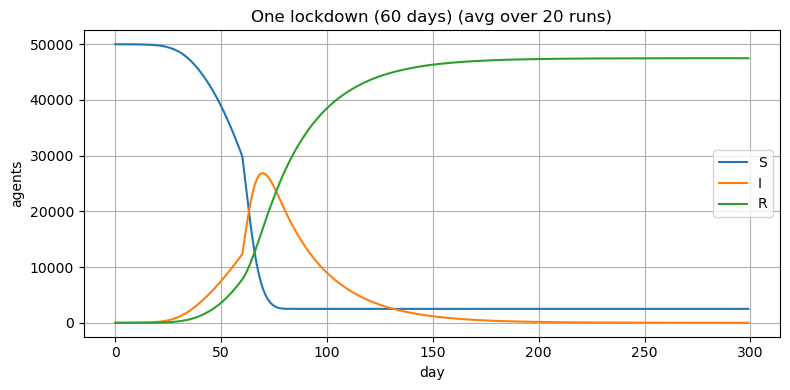

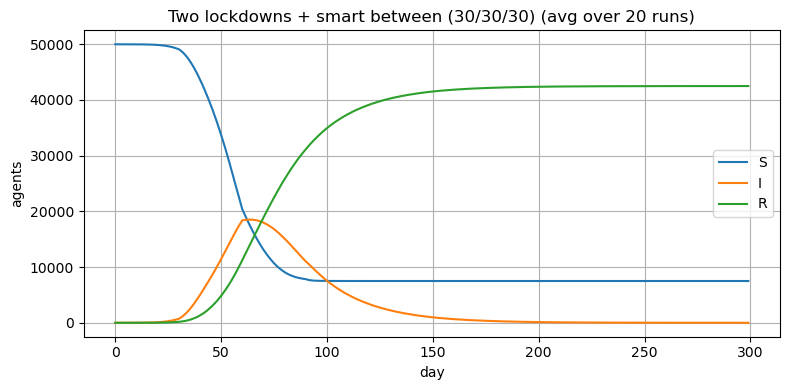

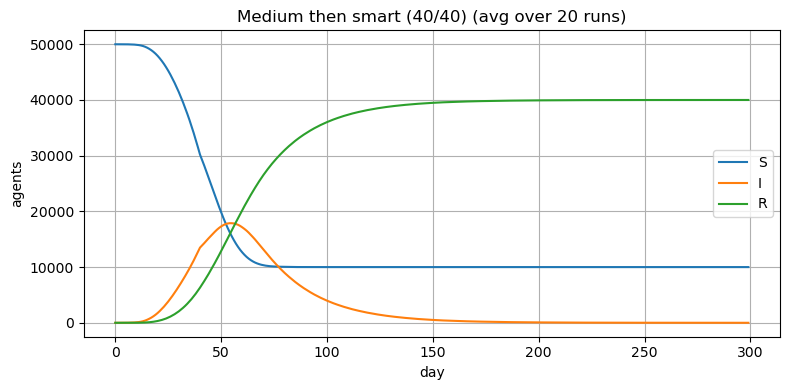

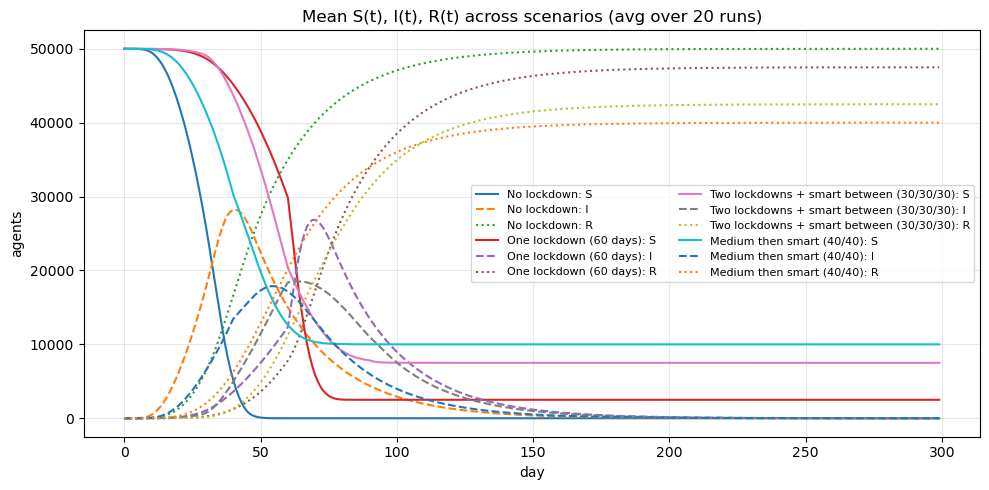

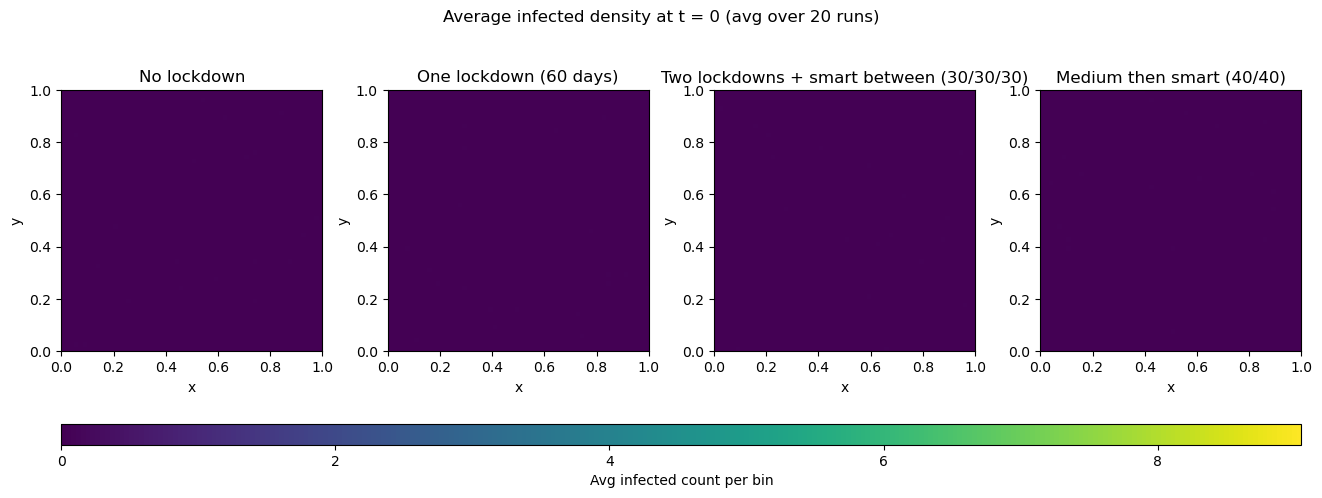

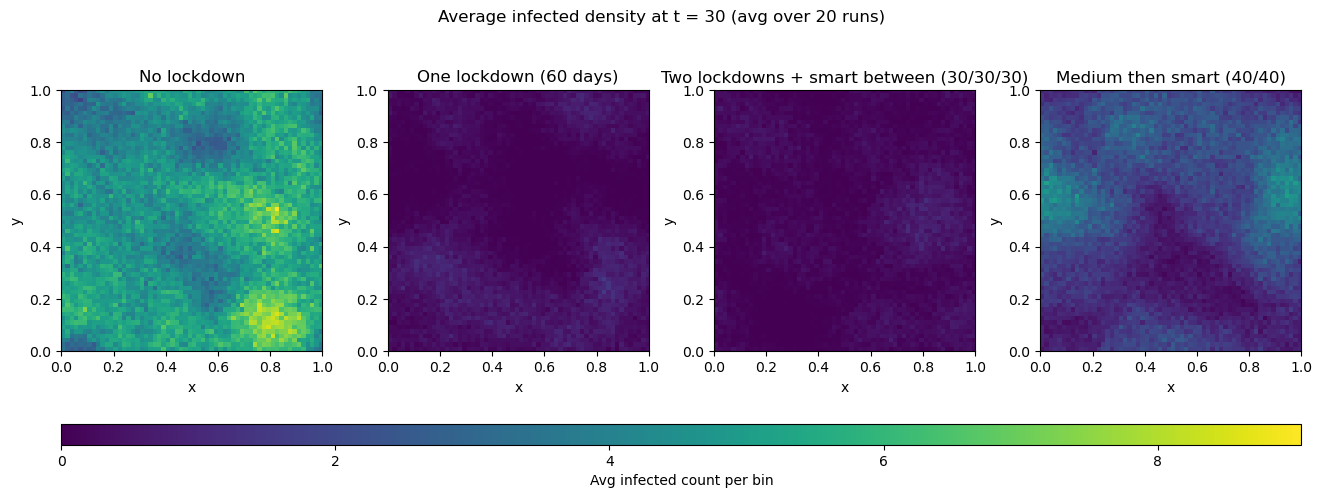

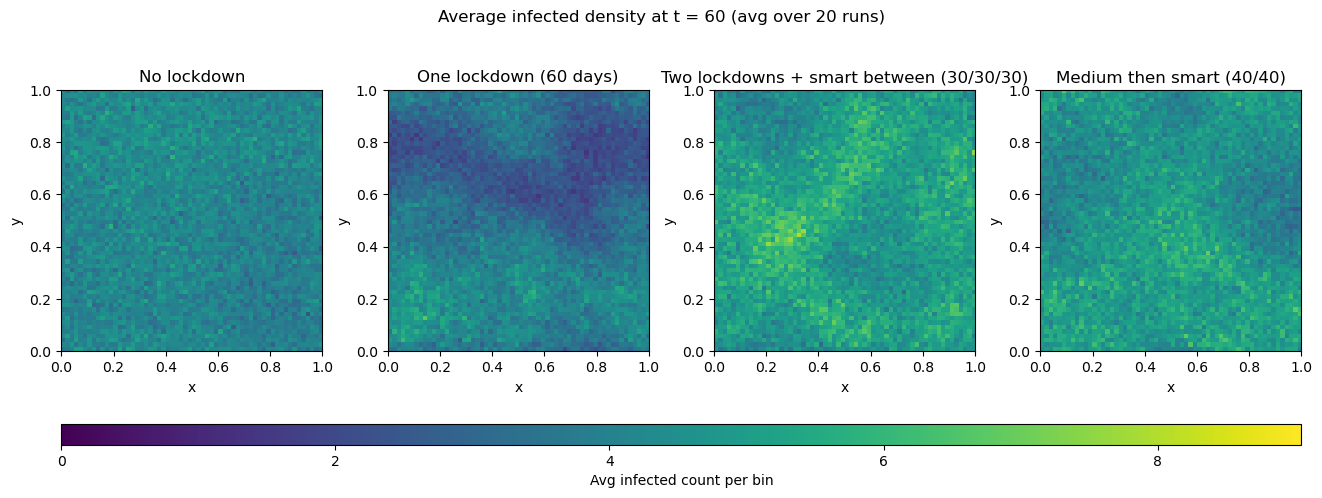

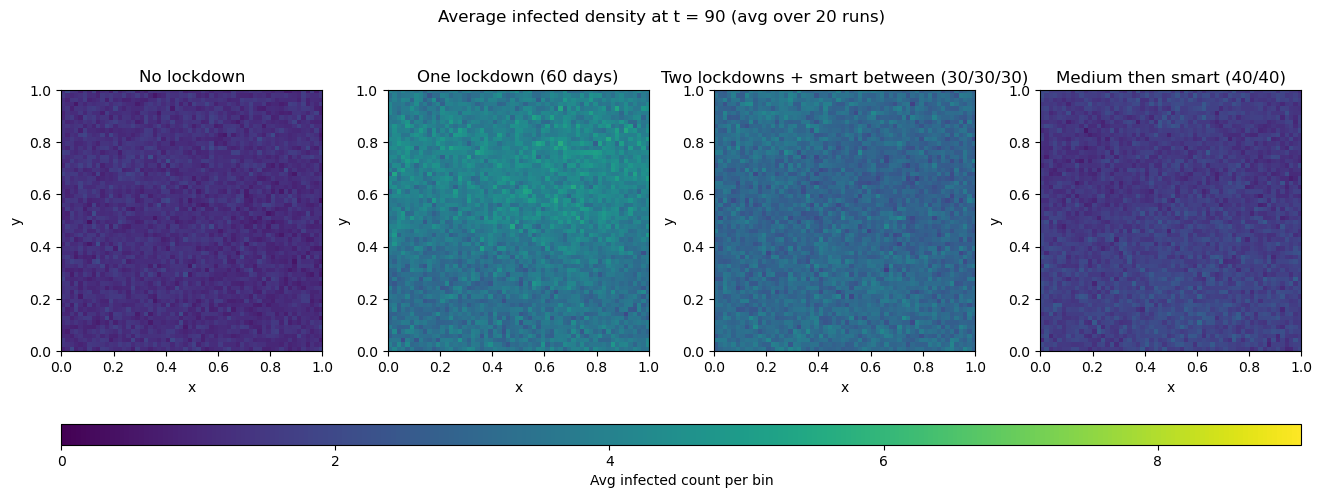

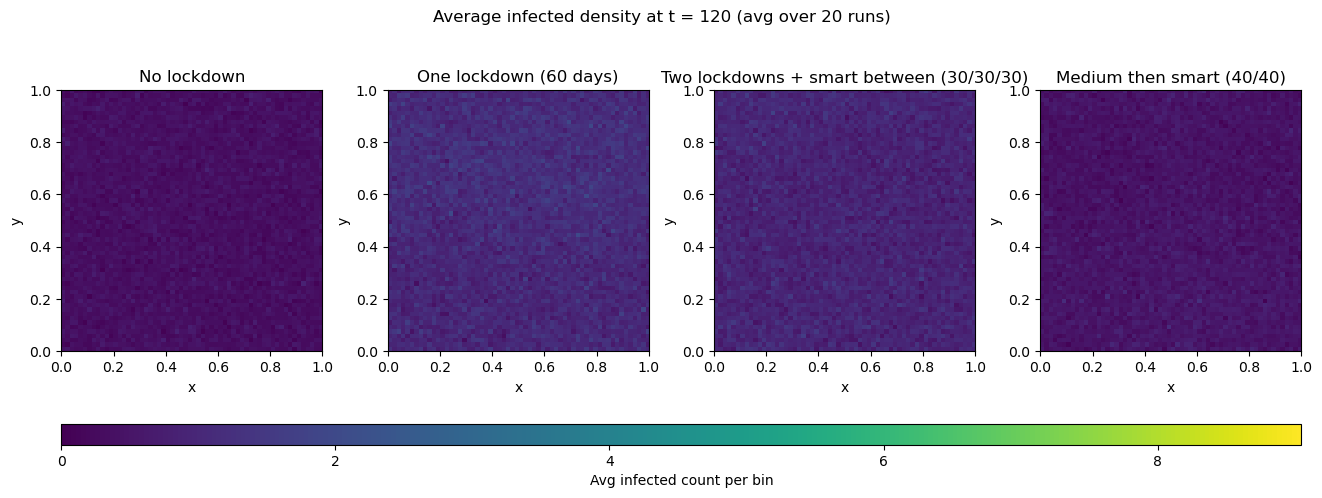

/var/folders/95/7gy2zsgx3fb01hntlvx9_p2w0000gn/T/ipykernel_28225/1286382806.py:435: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=False)


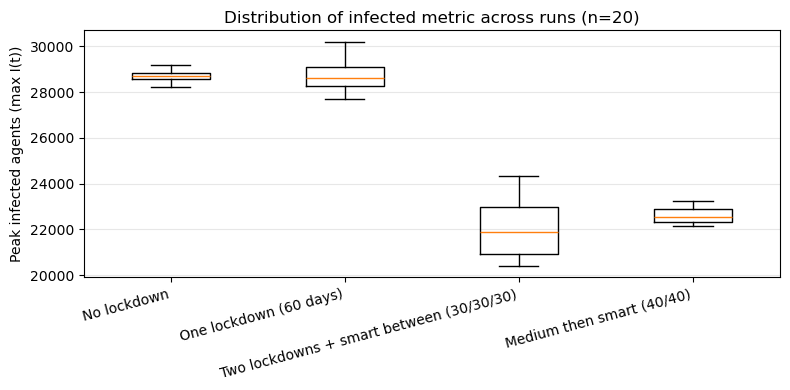

In [13]:
# =========================
# Imports
# =========================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from pathlib import Path

try:
    from scipy.spatial import cKDTree  # fast neighbor queries
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False
    print("WARNING: SciPy not found.")


# =========================
# Saving/export settings
# =========================
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

SAVE_FIGS = True        
DPI = 300               # image quality
SAVE_PDF_HEATMAPS = True  # save all heatmap panels into one PDF


# =========================
# Parameters + Scenarios
# =========================
# Population / time
N = 50_000          # agents
T = 300             # time steps ("days")
I0 = 1              # initially infected agents

# Disease
beta0 = 0.18        # infection probability per effective infectious contact per day
gamma = 0.04        # recovery probability per day

# Space & movement: random walk in [0,1]x[0,1] with reflecting boundaries
step_std = 0.015
contact_radius = 0.02

# Contact reduction multipliers (policy)
lockdown_contact_multiplier = 0.30      # hard lockdown: 30% of normal contacts
medium_contact_multiplier   = 0.60      # medium lockdown: 60% of normal contacts
smart_contact_multiplier_between = 0.50 # smart between two lockdowns: 50% contacts
smart_contact_multiplier_after   = 0.40 # smart after medium: 40% contacts

# Infected isolation
isolation_effectiveness = 0.90
infected_contact_factor = 1.0 - isolation_effectiveness  # = 0.10

# Durations
ONE_LOCKDOWN_DAYS  = 60
TWO_LOCKDOWN_DAYS  = 30
SMART_BETWEEN_DAYS = 30
MEDIUM_DAYS        = 40
SMART_AFTER_DAYS   = 40

SCENARIOS = [
    "none",
    "one_lockdown",
    "two_lockdowns_with_smart_between",
    "medium_then_smart",
]

pretty = {
    "none": "No lockdown",
    "one_lockdown": f"One lockdown ({ONE_LOCKDOWN_DAYS} days)",
    "two_lockdowns_with_smart_between": "Two lockdowns + smart between (30/30/30)",
    "medium_then_smart": "Medium then smart (40/40)",
}

# Heatmap settings
BINS = 60
SNAPSHOT_TIMES = [0, 30, 60, 90, 120]  

# Monte Carlo repeats
n_runs = 20
base_seed = 123


# =========================
# Helper functions
# =========================
def wrap_01(a):
    a = np.asarray(a)
    return np.mod(a, 1.0)


def contact_multiplier(scenario, t):
    """
    Returns c(t): fraction of normal contacts allowed by policy at time t.
    """
    if scenario == "none":
        return 1.0

    if scenario == "one_lockdown":
        return lockdown_contact_multiplier if t < ONE_LOCKDOWN_DAYS else 1.0

    if scenario == "two_lockdowns_with_smart_between":
        if t < TWO_LOCKDOWN_DAYS:
            return lockdown_contact_multiplier
        if t < TWO_LOCKDOWN_DAYS + SMART_BETWEEN_DAYS:
            return smart_contact_multiplier_between
        if t < 2 * TWO_LOCKDOWN_DAYS + SMART_BETWEEN_DAYS:
            return lockdown_contact_multiplier
        return 1.0

    if scenario == "medium_then_smart":
        if t < MEDIUM_DAYS:
            return medium_contact_multiplier
        if t < MEDIUM_DAYS + SMART_AFTER_DAYS:
            return smart_contact_multiplier_after
        return 1.0

    raise ValueError("Unknown scenario")


def infected_heatmap(x, y, status, bins=60):
    """
    Compute infected density heatmap as a 2D histogram over [0,1]x[0,1].
    Returns H with shape (bins, bins): counts of infected per spatial bin.
    """
    inf_mask = (status == 1)
    if not np.any(inf_mask):
        return np.zeros((bins, bins), dtype=float)

    H, _, _ = np.histogram2d(
        x[inf_mask], y[inf_mask],
        bins=bins,
        range=[[0.0, 1.0], [0.0, 1.0]]
    )
    return H.astype(float)


# =========================
# Simulation (returns S/I/R + snapshots)
# =========================
def simulate(scenario, seed=0, snapshot_times=None, bins=60):
    """
    One ABM run.
    Returns:
      S, I, R: arrays length T
      snapshots: dict {t: heatmap at time t} for t in snapshot_times
    """
    rng = np.random.default_rng(seed)

    # Initial positions
    x = rng.random(N)
    y = rng.random(N)

    # 0=S, 1=I, 2=R
    status = np.zeros(N, dtype=np.int8)
    status[rng.choice(N, size=I0, replace=False)] = 1

    S = np.zeros(T, dtype=int)
    I = np.zeros(T, dtype=int)
    R = np.zeros(T, dtype=int)

    snapshot_times = set(snapshot_times or [])
    snapshots = {}

    for t in range(T):
        # Record counts at the start of day t (before updating)
        S[t] = int(np.sum(status == 0))
        I[t] = int(np.sum(status == 1))
        R[t] = int(np.sum(status == 2))

        # Snapshot infected density at chosen times
        if t in snapshot_times:
            snapshots[t] = infected_heatmap(x, y, status, bins=bins)

        x = wrap_01(x + rng.normal(0.0, step_std, size=N))
        y = wrap_01(y + rng.normal(0.0, step_std, size=N))

        # Identify susceptible and infected
        sus = np.where(status == 0)[0]
        inf = np.where(status == 1)[0]

        # Policy contact multiplier + infected isolation factor
        c = contact_multiplier(scenario, t)
        c_eff = float(np.clip(c * infected_contact_factor, 0.0, 1.0))

        # Infection step
        if sus.size > 0 and inf.size > 0 and c_eff > 0.0:
            sus_pos = np.column_stack((x[sus], y[sus]))
            inf_pos = np.column_stack((x[inf], y[inf]))

            if HAVE_SCIPY:
                tree = cKDTree(inf_pos)
                neigh_lists = tree.query_ball_point(sus_pos, r=contact_radius)

                for j, neigh in enumerate(neigh_lists):
                    k = len(neigh)
                    if k == 0:
                        continue

                    # realized effective contacts under restrictions
                    k_contacts = rng.binomial(k, c_eff)
                    if k_contacts == 0:
                        continue

                    # infection probability from k_contacts
                    p_inf = 1.0 - (1.0 - beta0) ** k_contacts
                    if rng.random() < p_inf:
                        status[sus[j]] = 1

            else:
                r2 = contact_radius * contact_radius
                for sj in sus:
                    dx = x[sj] - x[inf]
                    dy = y[sj] - y[inf]
                    k = int(np.sum(dx * dx + dy * dy <= r2))
                    if k == 0:
                        continue

                    k_contacts = rng.binomial(k, c_eff)
                    if k_contacts == 0:
                        continue

                    p_inf = 1.0 - (1.0 - beta0) ** k_contacts
                    if rng.random() < p_inf:
                        status[sj] = 1

        # Recovery step
        inf_now = np.where(status == 1)[0]
        if inf_now.size > 0:
            rec = rng.random(inf_now.size) < gamma
            status[inf_now[rec]] = 2

    return S, I, R, snapshots


# =========================
# Run 
# =========================
results = {}       # scenario -> (Savg, Iavg, Ravg)
snap_results = {}  # scenario -> {t: avg_heatmap}

for s in SCENARIOS:
    S_acc = np.zeros(T, dtype=float)
    I_acc = np.zeros(T, dtype=float)
    R_acc = np.zeros(T, dtype=float)

    heat_acc = {tt: np.zeros((BINS, BINS), dtype=float) for tt in SNAPSHOT_TIMES}

    for r in range(n_runs):
        seed = base_seed + 1000 * SCENARIOS.index(s) + r
        S_run, I_run, R_run, snaps = simulate(
            s, seed=seed,
            snapshot_times=SNAPSHOT_TIMES,
            bins=BINS
        )

        S_acc += S_run
        I_acc += I_run
        R_acc += R_run

        for tt in SNAPSHOT_TIMES:
            heat_acc[tt] += snaps.get(tt, 0.0)

    results[s] = (S_acc / n_runs, I_acc / n_runs, R_acc / n_runs)
    snap_results[s] = {tt: (heat_acc[tt] / n_runs) for tt in SNAPSHOT_TIMES}


# =========================
# Plot S/I/R curves (one figure per scenario)
# =========================
t_axis = np.arange(T)

for s in SCENARIOS:
    Savg, Iavg, Ravg = results[s]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(t_axis, Savg, label="S")
    ax.plot(t_axis, Iavg, label="I")
    ax.plot(t_axis, Ravg, label="R")
    ax.set_title(f"{pretty.get(s, s)} (avg over {n_runs} runs)")
    ax.set_xlabel("day")
    ax.set_ylabel("agents")
    ax.grid(True)
    ax.legend()

    fig.tight_layout()

    if SAVE_FIGS:
        fig.savefig(FIG_DIR / f"sir_{s}.png", dpi=DPI, bbox_inches="tight")

    plt.show()
    plt.close(fig)

# =========================
# Overlay mean S(t), I(t), R(t) for all scenarios (single plot)
# =========================
fig, ax = plt.subplots(figsize=(10, 5))

# Use line style to distinguish compartments
ls = {"S": "-", "I": "--", "R": ":"}

for s in SCENARIOS:
    Savg, Iavg, Ravg = results[s]
    ax.plot(t_axis, Savg, linestyle=ls["S"], label=f"{pretty.get(s, s)}: S")
    ax.plot(t_axis, Iavg, linestyle=ls["I"], label=f"{pretty.get(s, s)}: I")
    ax.plot(t_axis, Ravg, linestyle=ls["R"], label=f"{pretty.get(s, s)}: R")

ax.set_title(f"Mean S(t), I(t), R(t) across scenarios (avg over {n_runs} runs)")
ax.set_xlabel("day")
ax.set_ylabel("agents")
ax.grid(True, alpha=0.3)

# Legend can get large; ncol helps
ax.legend(ncol=2, fontsize=8)

fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIG_DIR / "SIR_overlay_all_scenarios.png", dpi=DPI, bbox_inches="tight")

plt.show()
plt.close(fig)

# =========================
# heatmap panels 
# =========================
global_vmax = 0.0
for s in SCENARIOS:
    for tt in SNAPSHOT_TIMES:
        global_vmax = max(global_vmax, snap_results[s][tt].max())
if global_vmax == 0.0:
    global_vmax = 1.0 

# export all heatmap panels into one PDF
if SAVE_PDF_HEATMAPS:
    from matplotlib.backends.backend_pdf import PdfPages
    pdf_path = FIG_DIR / "heatmaps_all_times.pdf"
    pdf = PdfPages(pdf_path)
else:
    pdf = None

import matplotlib.gridspec as gridspec

for tt in SNAPSHOT_TIMES:
    fig = plt.figure(figsize=(4 * len(SCENARIOS), 5.0))

    # 2 rows: heatmaps + colorbar row
    gs = fig.add_gridspec(
        nrows=2,
        ncols=len(SCENARIOS),
        height_ratios=[22, 1.4],  
        hspace=0.25,               # vertical space between heatmaps and colorbar
        wspace=0.25
    )

    # Create heatmap axes (top row)
    ax0 = fig.add_subplot(gs[0, 0])
    axes = [ax0]
    for i in range(1, len(SCENARIOS)):
        axes.append(fig.add_subplot(gs[0, i], sharex=ax0, sharey=ax0))

    # One axis spanning the whole bottom row for the colorbar
    cax = fig.add_subplot(gs[1, :])

    ims = []
    for ax, s in zip(axes, SCENARIOS):
        H = snap_results[s][tt]
        im = ax.imshow(
            H.T,
            origin="lower",
            extent=[0, 1, 0, 1],
            vmin=0,
            vmax=global_vmax,
            aspect="equal"
        )
        ims.append(im)

        ax.set_title(pretty.get(s, s))
        ax.set_xlabel("x")
        ax.set_ylabel("y")

    # Colorbar goes into the dedicated bottom-row axis
    cbar = fig.colorbar(ims[0], cax=cax, orientation="horizontal")
    cbar.set_label("Avg infected count per bin")

    fig.suptitle(f"Average infected density at t = {tt} (avg over {n_runs} runs)", y=0.98)

    if SAVE_FIGS:
        fig.savefig(FIG_DIR / f"heatmap_panel_t{tt}.png", dpi=DPI, bbox_inches="tight", pad_inches=0.15)

    if pdf is not None:
        pdf.savefig(fig, bbox_inches="tight", pad_inches=0.15)

    plt.show()
    plt.close(fig)

# =========================
# Box plot
# =========================

# Collect one scalar infected metric per run, per scenario
infected_metric = {s: [] for s in SCENARIOS}

for s in SCENARIOS:
    for r in range(n_runs):
        seed = base_seed + 1000 * SCENARIOS.index(s) + r

        # Run again to keep the existing code unchanged 
        S_run, I_run, R_run, _ = simulate(
            s,
            seed=seed,
            snapshot_times=[],   # no heatmaps needed
            bins=BINS
        )

        # ---- Choose metric (pick ONE) ----
        # 1) Peak infected (max I(t))  <-- "number of infected" commonly shown as peak burden
        metric_value = int(np.max(I_run))

        # 2) Outbreak size (total ever infected) = N - S(T-1)
        # metric_value = int(N - S_run[-1])

        # 3) Infected at final day (I(T-1))
        # metric_value = int(I_run[-1])

        infected_metric[s].append(metric_value)

# Plot box plot
fig, ax = plt.subplots(figsize=(8, 4))

data = [infected_metric[s] for s in SCENARIOS]
labels = [pretty.get(s, s) for s in SCENARIOS]

ax.boxplot(data, labels=labels, showfliers=False)
ax.set_title(f"Distribution of infected metric across runs (n={n_runs})")
ax.set_ylabel("Peak infected agents (max I(t))")  # update if you switch metric above
ax.grid(True, axis="y", alpha=0.3)
plt.xticks(rotation=15, ha="right")

fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIG_DIR / "boxplot_peak_infected_by_scenario.png", dpi=DPI, bbox_inches="tight")

plt.show()
plt.close(fig)



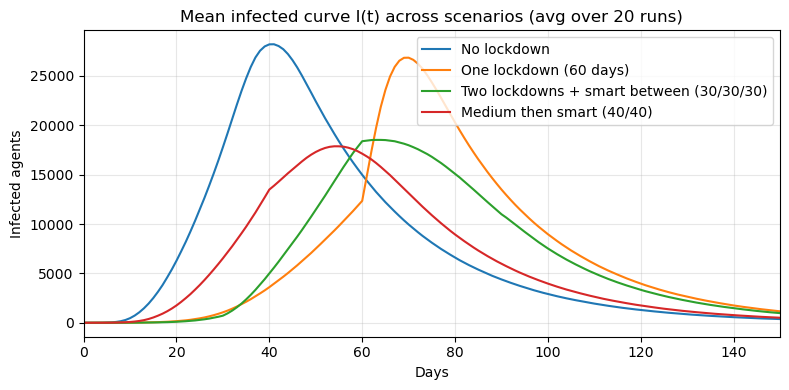

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))

for s in SCENARIOS:
    Savg, Iavg, Ravg = results[s]
    ax.plot(t_axis, Iavg, label=pretty.get(s, s))

ax.set_title(f"Mean infected curve I(t) across scenarios (avg over {n_runs} runs)")
ax.set_xlabel("Days")
ax.set_ylabel("Infected agents")
ax.set_xlim(0, 150)   
ax.grid(True, alpha=0.3)
ax.legend()

fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIG_DIR / "I_overlay_all_scenarios.png", dpi=DPI, bbox_inches="tight")

plt.show()
plt.close(fig)


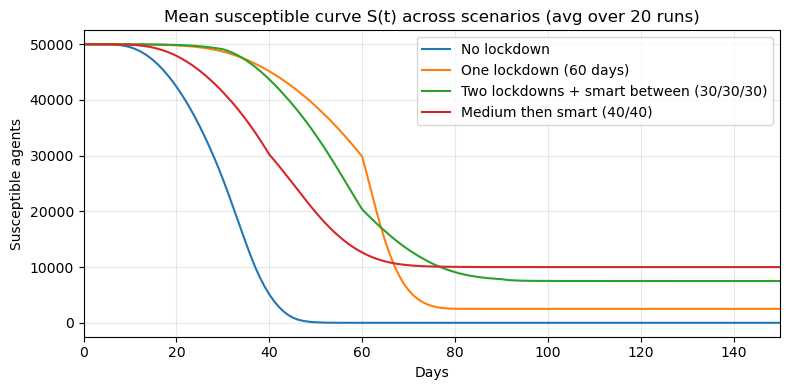

In [7]:
# =========================
# Overlay mean S(t) for all scenarios (single plot)
# =========================
fig, ax = plt.subplots(figsize=(8, 4))

for s in SCENARIOS:
    Savg, Iavg, Ravg = results[s]
    ax.plot(t_axis, Savg, label=pretty.get(s, s))

ax.set_title(f"Mean susceptible curve S(t) across scenarios (avg over {n_runs} runs)")
ax.set_xlabel("Days")
ax.set_ylabel("Susceptible agents")
ax.set_xlim(0, 150)   
ax.grid(True, alpha=0.3)
ax.legend()

fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIG_DIR / "S_overlay_all_scenarios.png", dpi=DPI, bbox_inches="tight")

plt.show()
plt.close(fig)


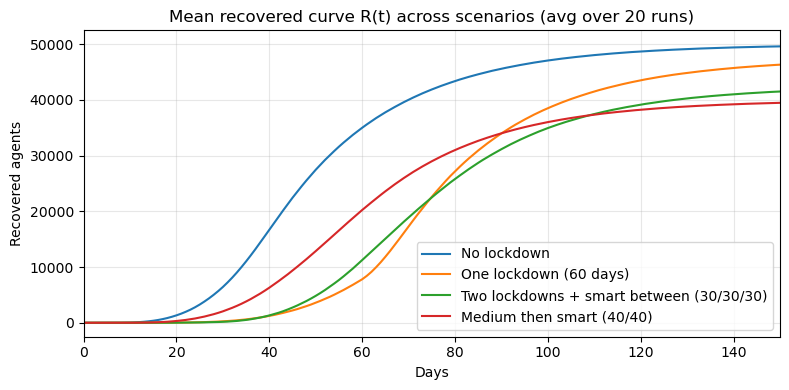

In [9]:
# =========================
# Overlay mean R(t) for all scenarios (single plot)
# =========================
fig, ax = plt.subplots(figsize=(8, 4))

for s in SCENARIOS:
    Savg, Iavg, Ravg = results[s]
    ax.plot(t_axis, Ravg, label=pretty.get(s, s))

ax.set_title(f"Mean recovered curve R(t) across scenarios (avg over {n_runs} runs)")
ax.set_xlabel("Days")
ax.set_ylabel("Recovered agents")
ax.set_xlim(0, 150)    
ax.grid(True, alpha=0.3)
ax.legend()

fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIG_DIR / "R_overlay_all_scenarios.png", dpi=DPI, bbox_inches="tight")

plt.show()
plt.close(fig)


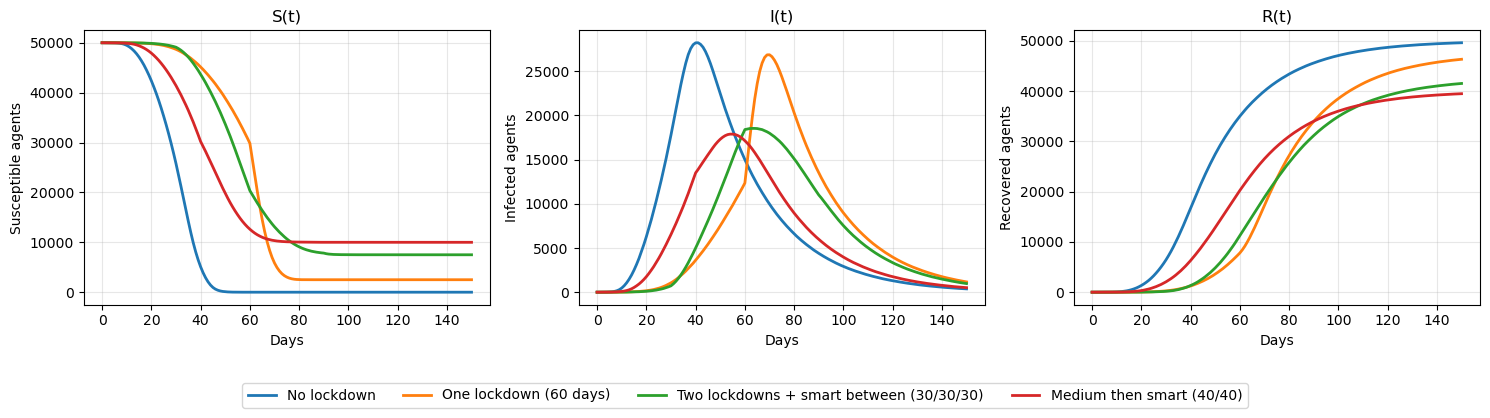

In [13]:
# =========================
# Combined figure: S(t), I(t), R(t) overlays in one row + ONE legend
# =========================
T_plot = 151  # set to 300 if you want full horizon
t_plot = t_axis[:T_plot]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

compartments = [("S", 0, "Susceptible agents"),
                ("I", 1, "Infected agents"),
                ("R", 2, "Recovered agents")]

handles_for_legend = None
labels_for_legend = None

for ax, (name, idx, ylabel) in zip(axes, compartments):
    for s in SCENARIOS:
        Savg, Iavg, Ravg = results[s]
        series = [Savg, Iavg, Ravg][idx][:T_plot]
        line, = ax.plot(t_plot, series, linewidth=2, label=pretty.get(s, s))

    ax.set_title(f"{name}(t)")
    ax.set_xlabel("Days")
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)

    # Grab legend handles/labels once (from the first subplot)
    if handles_for_legend is None:
        handles_for_legend, labels_for_legend = ax.get_legend_handles_labels()

# One legend for the entire figure (bottom center)
fig.legend(handles_for_legend, labels_for_legend,
           loc="lower center", ncol=len(SCENARIOS), frameon=True,
           bbox_to_anchor=(0.5, -0.05))

# Leave space for the legend
fig.tight_layout(rect=[0, 0.08, 1, 1])

if SAVE_FIGS:
    fig.savefig(FIG_DIR / "SIR_overlays_row_single_legend.png",
                dpi=DPI, bbox_inches="tight")

plt.show()
plt.close(fig)
